<a href="https://colab.research.google.com/github/danib08/Reconocimiento-de-Patrones/blob/Rain-In-Australia/Proyecto1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [5]:
!pip install --quiet optuna

In [6]:
import optuna
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from optuna import create_study, logging
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# Imputers
imputer_mode = SimpleImputer(strategy='most_frequent')
imputer_median = SimpleImputer(strategy='median')

# Algoritmos

## Regresión Logística

In [1]:
class OurLogisticRegression:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, lambda_=0):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
        self.lambda_ = lambda_  #parámetro de regularización

    def __add_intercept(self, X):
        # agregar 0s para ver la intersección con y
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)

    def __sigmoid(self, z):
        # función sigmoide
        return 1 / (1 + np.exp(-z))

    def __loss(self, h, y):
        # cross-entropy loss
        # un menos adelante ya que se busca el mínimo (derivada maximiza)
        loss = (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

        # término para regularización L2 (Ridge)
        reg_term = (self.lambda_ / (2 * len(y))) * np.sum(self.w[1:]**2)  # se excluye el intercept
        return loss + reg_term

    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)

        # inicialización de pesos
        self.w = np.zeros(X.shape[1])

        for i in range(self.num_iter):
            z = np.dot(X, self.w) # producto punto con los pesos
            h = self.__sigmoid(z) # se calculan las probabilidades

            # se calcula el gradiente
            # división por y.size para el promedio
            gradient = np.dot(X.T, (h-y)) / y.size

            # se calcula el término L2 (sin el intercept)
            regularization_term = (self.lambda_ / len(y)) * self.w[1:]

            # actualización de valores
            self.w[0] -= self.lr * gradient[0]
            self.w[1:] -= self.lr * (gradient[1:] + regularization_term)

    def predict_prob(self, X):
        # agregar 0s para mantener coherencia si fit_intercept es TRUE
        if self.fit_intercept:
            X = self.__add_intercept(X)
        return self.__sigmoid(np.dot(X, self.w))

    def predict(self, X, threshold):
        # asigna probabilidad binaria (0/1) según umbral
        return self.predict_prob(X) >= threshold

## K-Nearest Neighbors

In [2]:
class OurKNearest():
    def __init__(self, X_train, y_train, n_neighbors=5, weights='distance', n_classes=2):

        # dataset para entrenamiento
        self.X_train = X_train
        self.y_train = y_train

        self.n_neighbors = n_neighbors # K vecinos a usar para la decisión
        self.weights = weights

        # número de categorías / clases en el dataset
        self.n_classes = n_classes

    # distancia euclidiana entre dos puntos (vectores)
    def euclidian_distance(self, a, b):
        return np.sqrt(np.sum((a - b)**2, axis=1))

    # para cada punto en X_test, se calculan las distancias a todos los puntos en X_train,
    # y luego se seleccionan los k vecinos más cercanos.
    # los índices de estos vecinos y sus distancias se guardan en listas
    def kneighbors(self, X_test, return_distance=False):
        dist = []
        neigh_ind = []

        if self.weights == 'distance':
          return_distance = True

        point_dist = []
        for x_test in X_test:
            # para cada punto en X_test, se calculan las distancias a todos los puntos en X_train
            # lista de arrays (filas) con distancias por cada punto en X_test
            # fila 1 = distancias entre X_test[1] a los X_train
            point_dist += [self.euclidian_distance(x_test, self.X_train)]

        for row in point_dist:
            # enumera cada fila (le agrega índices)
            enum_neigh = enumerate(row)
            # ordena cada fila según la distancia (menor a mayor)
            # slice según k, para dejar solo los k vecinos mas cercanos (# vecinos)
            sorted_neigh = sorted(enum_neigh,
                                  key=lambda x: x[1])[:self.n_neighbors]

            ind_list = [tup[0] for tup in sorted_neigh]  # lista de arrays con los indices de cada fila (x_test)
            dist_list = [tup[1] for tup in sorted_neigh] # lista de arrays con las distancias de cada fila (x_test)

            dist.append(dist_list)
            neigh_ind.append(ind_list)

        # true para weights="distance"
        if return_distance:
            return np.array(dist), np.array(neigh_ind)

        return np.array(neigh_ind) # retorna filas de k indices cercanos por cada x_test

    # prediccion de un Y a partir de un X
    def predict(self, X_test):

        if self.weights == 'uniform': # la mayor cantidad de vecinos de la misma clase gana
          neighbors = self.kneighbors(X_test) # filas con índices por cada x_test

          # bincount: cuenta el número de ocurrencias de cada valor en un array
          # argmax: retorna índices de los valores máximos en un array
          y_pred = np.array([
              np.argmax(np.bincount(self.y_train[neighbor]))
              for neighbor in neighbors # recorriendo indices
          ])
          return y_pred

        # weighted knn
        if self.weights == 'distance':
          dist, neigh_ind = self.kneighbors(X_test)
          y_pred = []

          # se obtienen las clases de los vecinos
          clases = self.y_train[neigh_ind]

          # se calculan los pesos de los vecinos
          weights = 1 / dist

          # inicializa array para predicciones
          y_pred = np.empty(dist.shape[0], dtype=int)

          for i in range(dist.shape[0]):
              # suma los pesos de los vecinos por clase
              class_weights = np.bincount(clases[i], weights=weights[i], minlength=self.n_classes)

              # encuentra la clase con mayor peso
              predicted_class = np.argmax(class_weights)
              y_pred[i] = predicted_class

          return np.array(y_pred)

## Árboles de Decisión

In [3]:
# Definición de la función para calcular la entropía
def entropy(y):
    unique, counts = np.unique(y, return_counts=True)
    probabilities = counts / len(y)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    return entropy

# Definición de la función para dividir los datos
def split_data(X, y, feature_index, threshold):
    left_mask = X[:, feature_index] <= threshold
    right_mask = ~left_mask
    X_left, y_left = X[left_mask], y[left_mask]
    X_right, y_right = X[right_mask], y[right_mask]
    return X_left, y_left, X_right, y_right

# Definición de la clase del nodo del árbol de decisión
class Node:
    def __init__(self, depth=0, max_depth=None):
        self.depth = depth
        self.max_depth = max_depth
        self.feature_index = None
        self.threshold = None
        self.left = None
        self.right = None
        self.value = None

    def fit(self, X, y):
        unique_classes, class_counts = np.unique(y, return_counts=True)
        self.value = unique_classes[np.argmax(class_counts)]
        if self.depth == self.max_depth or len(unique_classes) == 1: # Se pregunta las dos condiciones de paradas, sin divisiones y profundidad máxima
            return

        num_features = X.shape[1] # cantidad de Features
        best_info_gain = -1 # métrica

        for feature_index in range(num_features):
            thresholds = np.unique(X[:, feature_index])
            for threshold in thresholds:
                X_left, y_left, X_right, y_right = split_data(X, y, feature_index, threshold)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                info_gain = entropy(y) - ((len(y_left) / len(y)) * entropy(y_left) + (len(y_right) / len(y)) * entropy(y_right))

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    self.feature_index = feature_index
                    self.threshold = threshold

        if self.feature_index is not None:
            X_left, y_left, X_right, y_right = split_data(X, y, self.feature_index, self.threshold)
            self.left = Node(depth=self.depth + 1, max_depth=self.max_depth)
            self.left.fit(X_left, y_left)
            self.right = Node(depth=self.depth + 1, max_depth=self.max_depth)
            self.right.fit(X_right, y_right)

    def predict(self, X):
        if self.feature_index is None:
            return self.value
        if X[self.feature_index] <= self.threshold:
            return self.left.predict(X)
        else:
            return self.right.predict(X)

# Rain in Australia

## Feature Engineering

### Información descriptiva del dataset

Se puede notar que hay variables tanto numéricas como categóricas, y que contienen valores nulos o faltantes.

In [7]:
data = pd.read_csv("https://raw.githubusercontent.com/danib08/Datasets-Patrones/main/weatherAUS.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

### Visualización de Sesgo

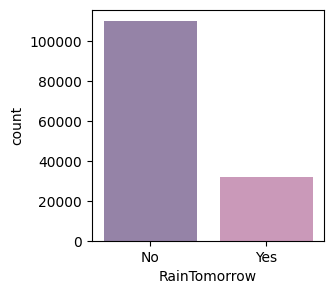

In [8]:
colors= ["#957DAD","#D291BC"]
plt.figure(figsize=(3, 3))
sns.countplot(x=data["RainTomorrow"], palette=colors)
plt.show()

### Matriz de correlación

Las variables cuyo valor de correlación se acerque más a 1, pueden llegar a ser redundantes en el modelo. En este caso, se optó por eliminar las features 'Temp9am' y 'Temp3pm' debido al análisis del heat map y a prueba y error de las mejores combinaciones.

<Axes: >

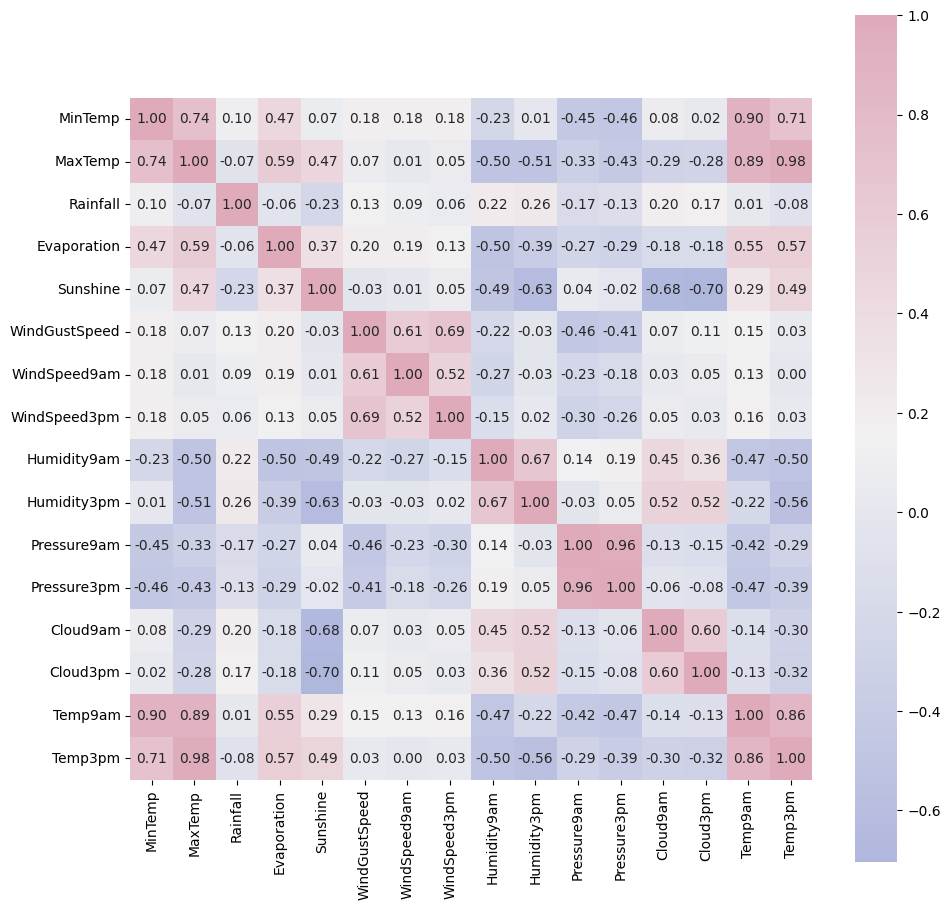

In [9]:
corrmat = data.corr(numeric_only=True)
cmap = sns.diverging_palette(260, -10, s=50, l=75, n=6, as_cmap=True)
plt.subplots(figsize=(11,11))
sns.heatmap(corrmat, cmap=cmap, annot=True, square=True, fmt='.2f')

### Parseando feature "Date" de manera cíclica

Text(0.5, 0, 'seno')

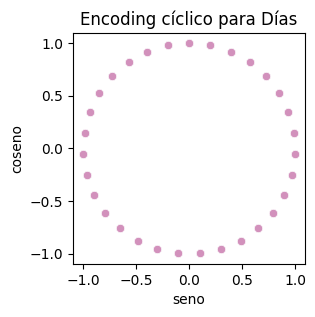

In [10]:
data['Date']= pd.to_datetime(data["Date"])  # convertir en datetime
data['year'] = data.Date.dt.year # nueva columna extrayendo el año

# encoding para datos con comportamiento cíclico (mes y día)
def cyclic_encoding(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

data['month'] = data.Date.dt.month
data = cyclic_encoding(data, 'month', 12)

data['day'] = data.Date.dt.day
data = cyclic_encoding(data, 'day', 31)

plt.figure(figsize=(3, 3))
cyclic_day = sns.scatterplot(x='day_sin', y='day_cos' ,data=data, color="#D291BC")
cyclic_day.set_title("Encoding cíclico para Días")
cyclic_day.set_ylabel("coseno")
cyclic_day.set_xlabel("seno")

### División set de Training / Test


In [11]:
data['RainTomorrow'] = data['RainTomorrow'].replace({'Yes': 1, 'No': 0})
data['RainTomorrow'] = imputer_mode.fit_transform(data[['RainTomorrow']])

target = data['RainTomorrow']
features = data.drop(['RainTomorrow', 'Date', 'day', 'month', 'Temp9am', 'Temp3pm'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42, stratify=target)

### Valores nulos - Variables numéricas

In [12]:
# variables numéricas
nums = (X_train.dtypes == "float64") | (X_train.dtypes == "int64")
numerical = list(nums[nums].index)

# reemplazar nulos por mediana de columna respectiva
X_train[numerical] = imputer_median.fit_transform(X_train[numerical])
X_test[numerical] = imputer_median.transform(X_test[numerical])

# visualizar total de valores nulos
null_counts = X_train[numerical].apply(lambda x: x.isnull().sum())
print(null_counts)

MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustSpeed    0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
year             0
month_sin        0
month_cos        0
day_sin          0
day_cos          0
dtype: int64


### Valores nulos - Variables categóricas

In [13]:
# variables categóricas
objs = (X_train.dtypes == "object")
categories = list(objs[objs].index)

# reemplazar nulos por moda de columna respectiva
X_train[categories] = imputer_mode.fit_transform(X_train[categories])
X_test[categories] = imputer_mode.transform(X_test[categories])

# visualizar total de valores nulos
null_counts = X_train[categories].apply(lambda x: x.isnull().sum())
print(null_counts)

Location       0
WindGustDir    0
WindDir9am     0
WindDir3pm     0
RainToday      0
dtype: int64


### Encoding de strings a valores numéricos

In [14]:
label_encoder = LabelEncoder()

combined_data = pd.concat([X_train, X_test], axis=0)
combined_data[categories] = combined_data[categories].apply(lambda col: label_encoder.fit_transform(col))

X_train = combined_data.iloc[:len(X_train)]
X_test = combined_data.iloc[len(X_train):]

### Normalización

In [15]:
s_scaler = StandardScaler()

col_names = list(combined_data.columns)

X_train = s_scaler.fit_transform(X_train)
X_test = s_scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=col_names)
X_test = pd.DataFrame(X_test, columns=col_names)

### Análisis de Outliers / Caja de Bigotes


Gracias al diagrama de la Caja de Bigotes, se puede observar que hay outliers presentes en las features Rainfall, Evaporation, WindGustSpeed, WindSpeed9am y WindSpeed3pm, por lo que se aplicará un análisis de los cuartiles usando el límite superior como delimitante para los outliers.

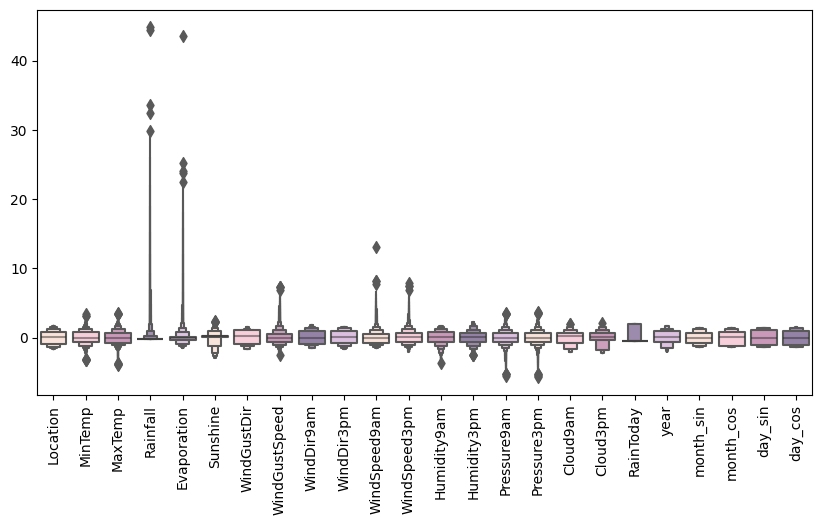

In [16]:
combined_data = pd.concat([X_train, X_test], axis=0)

colors = ["#FFDFD3", "#FEC8D8", "#D291BC", "#957DAD", "#E0BBE4"]
plt.figure(figsize=(10,5))
sns.boxenplot(data = combined_data, palette = colors)
plt.xticks(rotation=90)
plt.show()

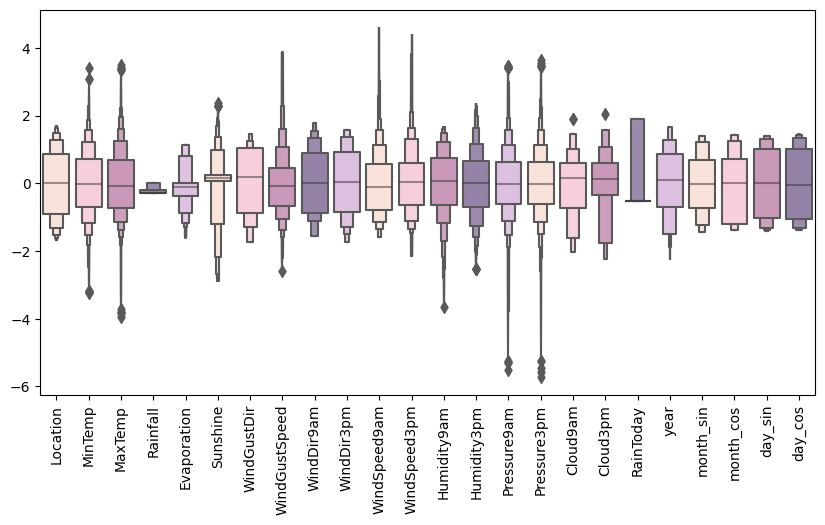

In [17]:
# funcion para eliminar outliers
def remove_outliers(dataframe, column, multiplier=3):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_fence = Q1 - (IQR * multiplier)
    upper_fence = Q3 + (IQR * multiplier)

    return np.where(dataframe[column] > upper_fence, upper_fence, dataframe[column])

# features en las cuales se eliminaran outliers
features_to_remove_outliers = ['Rainfall', 'Evaporation', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']

for feature in features_to_remove_outliers:
    combined_data[feature] = remove_outliers(combined_data, feature)


plt.figure(figsize=(10,5))
sns.boxenplot(data = combined_data, palette = colors)
plt.xticks(rotation=90)
plt.show()

### Reducción de sesgo

In [18]:
X_train = combined_data.iloc[:len(X_train)]
X_test = combined_data.iloc[len(X_train):]

unique, counts = np.unique(y_train, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Distribución antes de SMOTE:", class_distribution)

smote = SMOTE(random_state=42, sampling_strategy=0.80)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

unique, counts = np.unique(y_resampled, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Distribución después de SMOTE:", class_distribution)

Distribución antes de SMOTE: {0.0: 79508, 1.0: 22314}
Distribución después de SMOTE: {0.0: 79508, 1.0: 63606}


## Regresión Logística

### Entrenamiento


Se entrenarán dos modelos con dos datasets distintos, uno balanceado y el otro no, para ver los resultados y ventajas/desventajas de cada uno.

In [ ]:
our_logreg = OurLogisticRegression(0.15, 20000)
our_logreg_balanced = OurLogisticRegression(0.15, 20000)

our_logreg.fit(X_train, y_train)
our_logreg_balanced.fit(X_resampled, y_resampled)

### Testing

Se harán predicciones con el dataset balanceado y el original sesgado, tanto para testing como entrenamiento, para observar las distintas mejoras.

In [ ]:
# predicciones con dataset desbalanceado
y_pred_logreg = our_logreg.predict(X_test, threshold=0.5)
y_pred_train_logreg = our_logreg.predict(X_train, threshold=0.5)
y_prob_logreg = our_logreg.predict_prob(X_test)

# predicciones con dataset balanceado

y_pred_logreg_balanced = our_logreg_balanced.predict(X_test, threshold=0.5)
y_pred_train_logreg_balanced = our_logreg_balanced.predict(X_resampled, threshold=0.5)
y_prob_logreg_balanced = our_logreg_balanced.predict_prob(X_test)

### Métricas y Análisis Inicial

Para el accuracy, se puede observar que esta disminuye de manera mínima al utilizar el dataset balanceado, sin embargo, es algo común al utilizar SMOTE para balancear el set de datos, ya que se crean datos sintéticos que pueden introducir ruido o clasificaciones erróneas. Esto puede causar que el accuracy en general disminuya pero se mejoren otras métricas, como se observa en los próximos apartados.

In [ ]:
# accuracy
our_logreg_train_accuracy = accuracy_score(y_train, y_pred_train_logreg)
our_logreg_accuracy = accuracy_score(y_test, y_pred_logreg)

our_logreg_balanced_train_accuracy = accuracy_score(y_resampled, y_pred_train_logreg_balanced)
our_logreg_balanced_accuracy = accuracy_score(y_test, y_pred_logreg_balanced)

print('Our training accuracy: {0:0.8f}'. format(our_logreg_train_accuracy))
print('Our test accuracy:     {0:0.8f}'. format(our_logreg_accuracy))
print("\n")
print('Our balanced training accuracy: {0:0.8f}'. format(our_logreg_balanced_train_accuracy))
print('Our balanced test accuracy:     {0:0.8f}'. format(our_logreg_balanced_accuracy))

Our training accuracy: 0.84341301
Our test accuracy:     0.84589120


Our balanced training accuracy: 0.78338248
Our balanced test accuracy:     0.80413859


La matriz de confusión para el dataset sesgado muestra que básicamente la predicción de los valores positivos (lloverá) se hace casi que de manera 50/50, lo que se debe al alto sesgo. Es decir, la mitad de las observaciones verdaderas de que va a llover, se clasifican como negativas.

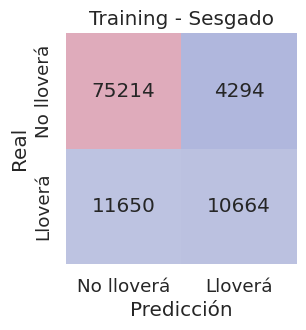

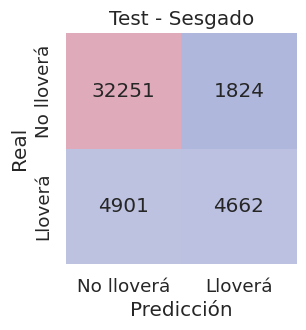

In [ ]:
# confusion matrix
cm_train = confusion_matrix(y_train, y_pred_train_logreg)
cm_test = confusion_matrix(y_test, y_pred_logreg)

class_names = ["No lloverá", "Lloverá"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training - Sesgado')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test - Sesgado')
plt.show()

En cambio, la matriz de confusión para el dataset balanceado muestra que ahora disminuye la cantidad de Falsos Negativos (FN), es decir, la clasificación de observaciones reales de que va a llover, como que no lo hará. Esto hace mucho más fiable la clasificación de la clase negativa, que estaba siendo mala en el caso anterior.

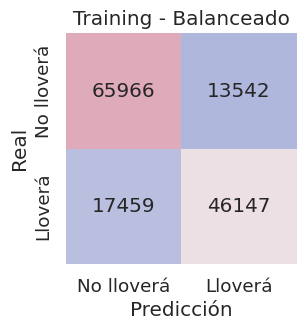

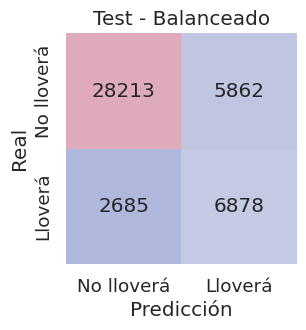

In [ ]:
# confusion matrix
cm_train = confusion_matrix(y_resampled, y_pred_train_logreg_balanced)
cm_test = confusion_matrix(y_test, y_pred_logreg_balanced)

class_names = ["No lloverá", "Lloverá"]

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_train, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Training - Balanceado')
plt.show()

sns.set(font_scale=1.2)
plt.figure(figsize=(3, 3))
sns.heatmap(cm_test, annot=True, fmt="d", cmap=cmap , cbar=False, square=True,
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Test - Balanceado')
plt.show()

Para el caso del dataset sesgado, no se observa overfitting ni underfitting, ya que los valores de precisión, recall y F1 score se mantienen parecidos en el entrenamiento y el testeo.

Para el dataset balanceado, se observa un poco de overfitting en la preicisión, ya que dicha métrica reducen su valor en el caso del testing, en comparación al entrenamiento. Sin embargo, es destacable el hecho de que se logró un aumento en el Recall y el F1 score. Tanto el Recall como Precision poseen un trade-off, si una aumenta, la otra disminuirá.

Para este modelo, se considera que los Falsos Negativos deben minimizarse, ya que es más crítico predecir que no va a llover cuando en realidad sí lo hace. En otras palabras, se quieren minimizar los errores de Tipo 2 por sobre los Tipo 1.

Por lo tanto, se busca aumentar el recall (aceptando un trade-off por la disminución de la precisión), en el contexto de este problema de clasificación, al mismo tiempo que mantener un buen F1 Score (balance entre precision y recall).

In [ ]:
# precision, recall, f1

# sesgo
our_logreg_train_precision = precision_score(y_train, y_pred_train_logreg)
our_logreg_train_recall = recall_score(y_train, y_pred_train_logreg)
our_logreg_train_f1 = f1_score(y_train, y_pred_train_logreg)

our_logreg_precision = precision_score(y_test, y_pred_logreg)
our_logreg_recall = recall_score(y_test, y_pred_logreg)
our_logreg_f1 = f1_score(y_test, y_pred_logreg)

# balanceado
our_logreg_balanced_train_precision = precision_score(y_resampled, y_pred_train_logreg_balanced)
our_logreg_balanced_train_recall = recall_score(y_resampled, y_pred_train_logreg_balanced)
our_logreg_balanced_train_f1 = f1_score(y_resampled, y_pred_train_logreg_balanced)

our_logreg_balanced_precision = precision_score(y_test, y_pred_logreg_balanced)
our_logreg_balanced_recall = recall_score(y_test, y_pred_logreg_balanced)
our_logreg_balanced_f1 = f1_score(y_test, y_pred_logreg_balanced)

print("DATASET SESGADO")
print('Our training precision: {0:0.8f}'. format(our_logreg_train_precision))
print('Our training recall:    {0:0.8f}'. format(our_logreg_train_recall))
print('Our training F1:        {0:0.8f}'. format(our_logreg_train_f1))
print("\n")
print('Our test precision: {0:0.8f}'. format(our_logreg_precision))
print('Our test recall:    {0:0.8f}'. format(our_logreg_recall))
print('Our test F1:        {0:0.8f}'. format(our_logreg_f1))
print("\n")
print("DATASET BALANCEADO")
print('Our training precision: {0:0.8f}'. format(our_logreg_balanced_train_precision))
print('Our training recall:    {0:0.8f}'. format(our_logreg_balanced_train_recall))
print('Our training F1:        {0:0.8f}'. format(our_logreg_balanced_train_f1))
print("\n")
print('Our test precision: {0:0.8f}'. format(our_logreg_balanced_precision))
print('Our test recall:    {0:0.8f}'. format(our_logreg_balanced_recall))
print('Our test F1:        {0:0.8f}'. format(our_logreg_balanced_f1))

DATASET SESGADO
Our training precision: 0.71292954
Our training recall:    0.47790625
Our training F1:        0.57222580


Our test precision: 0.71877891
Our test recall:    0.48750392
Our test F1:        0.58097078


DATASET BALANCEADO
Our training precision: 0.77312403
Our training recall:    0.72551332
Our training F1:        0.74856239


Our test precision: 0.53987441
Our test recall:    0.71923037
Our test F1:        0.61677801


El AUC da un valor bastante alto, lo que implica que el modelo es bueno en su capacidad de separar los eventos de lluvia de los eventos sin lluvia. Un AUC = 1 es el ideal, por lo que entonces el valor obtenido es bastante bueno.

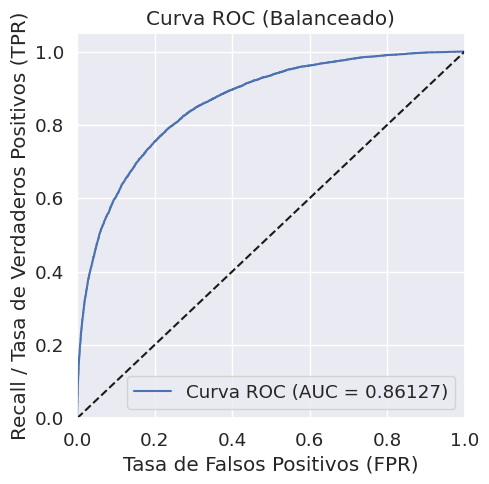

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg_balanced)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC (Balanceado)')
plt.legend(loc="lower right")
plt.show()

### Ajuste de Hiperparámetros

In [ ]:
def objective(trial):
    lr = trial.suggest_float('lr', 0.10, 0.5, log=True)

    model = OurLogisticRegression(lr=lr, num_iter=20000)

    model.fit(X_resampled, y_resampled)

    y_pred = model.predict(X_test, threshold=0.5)

    # métricas a optimizar
    recall = recall_score(y_test, y_pred)

    return recall

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

best_params = study.best_params
best_recall_score = study.best_value

[I 2023-09-28 16:38:17,339] A new study created in memory with name: no-name-0e4a416a-210b-453c-a438-e6ce6644dcc7
[I 2023-09-28 16:42:00,313] Trial 0 finished with value: 0.7194395064310363 and parameters: {'lr': 0.20784442559558214}. Best is trial 0 with value: 0.7194395064310363.
[I 2023-09-28 16:45:47,451] Trial 1 finished with value: 0.7205897730837604 and parameters: {'lr': 0.4280682579557548}. Best is trial 1 with value: 0.7205897730837604.
[I 2023-09-28 16:49:16,918] Trial 2 finished with value: 0.7201714943009516 and parameters: {'lr': 0.32117546172828615}. Best is trial 1 with value: 0.7205897730837604.
[I 2023-09-28 16:54:26,112] Trial 3 finished with value: 0.719857785213845 and parameters: {'lr': 0.3012912757705529}. Best is trial 1 with value: 0.7205897730837604.
[I 2023-09-28 16:58:16,269] Trial 4 finished with value: 0.7199623549095472 and parameters: {'lr': 0.2779815137346763}. Best is trial 1 with value: 0.7205897730837604.
[I 2023-09-28 17:01:34,144] Trial 5 finished 

### Regularización

Se utiliza el término lambda para aplicar la regularización de tipo L2 (Ridge) al modelo y así intentar disminuir el overfitting en el modelo, además del learning rate optimizado por Optuna.

In [ ]:
our_logreg_reg = OurLogisticRegression(best_params['lr'], 20000, True, lambda_=8)

our_logreg_reg.fit(X_resampled, y_resampled)

y_pred_logreg_reg = our_logreg_reg.predict(X_test, threshold=0.5)
y_pred_train_logreg_reg = our_logreg_reg.predict(X_resampled, threshold=0.5)

y_prob_logreg_reg = our_logreg_reg.predict_prob(X_test)

Después de variar el parámetro lambda para intentar obtener distintos resultados, se logró un aumento (aunque pequeño) en las métricas de recall y F1. Aún así, estas son menores a las de training, porlo que sigue estando presente el overfitting.

De igual manera se establece que el recall más alto que la precisión es lo que se buscaba en el modelo, debido a que se prefiere evitar tener falsos negativos que falsos positivos. Además, el AUC tiene un valor alto, lo que indica que el modelo a pesar de sus imperfecciones, en general es uno "bueno".

In [ ]:
# accuracy, precision, recall, f1
our_logreg_balanced_train_accuracy = accuracy_score(y_resampled, y_pred_train_logreg_reg)
our_logreg_balanced_train_precision = precision_score(y_resampled, y_pred_train_logreg_reg)
our_logreg_balanced_train_recall = recall_score(y_resampled, y_pred_train_logreg_reg)
our_logreg_balanced_train_f1 = f1_score(y_resampled, y_pred_train_logreg_reg)

our_logreg_balanced_accuracy = accuracy_score(y_test, y_pred_logreg_reg)
our_logreg_balanced_precision = precision_score(y_test, y_pred_logreg_reg)
our_logreg_balanced_recall = recall_score(y_test, y_pred_logreg_reg)
our_logreg_balanced_f1 = f1_score(y_test, y_pred_logreg_reg)

print('Our training accuracy:  {0:0.8f}'. format(our_logreg_balanced_train_accuracy))
print('Our training precision: {0:0.8f}'. format(our_logreg_balanced_train_precision))
print('Our training recall:    {0:0.8f}'. format(our_logreg_balanced_train_recall))
print('Our training F1:        {0:0.8f}'. format(our_logreg_balanced_train_f1))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_logreg_balanced_accuracy))
print('Our test precision: {0:0.8f}'. format(our_logreg_balanced_precision))
print('Our test recall:    {0:0.8f}'. format(our_logreg_balanced_recall))
print('Our test F1:        {0:0.8f}'. format(our_logreg_balanced_f1))

Our training accuracy:  0.78322875
Our training precision: 0.77301292
Our training recall:    0.72521460
Our training F1:        0.74835130


Our test accuracy:  0.80491773
Our test precision: 0.54125413
Our test recall:    0.72027606
Our test F1:        0.61806272


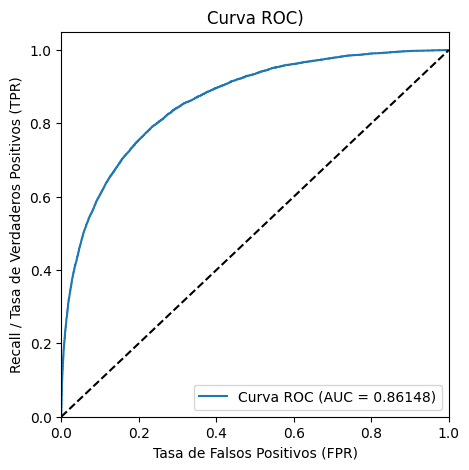

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_logreg_reg)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC)')
plt.legend(loc="lower right")
plt.show()

### Resultados finales - Ajuste de Umbral

Por último, se probarán distintos umbrales para mejorar el recall. Sin embargo, al mejorarlo cada vez más, se obtiene una precisión menor y el F1 por lo tanto baja su valor. Es por esto que se decidió mantener un umbral muy cercano al default de 0.5, y así mantener la accuracy en 0.8 y el recall en 0.7.

In [ ]:
optimal_threshold = 0.49

y_pred_logreg_reg = our_logreg_reg.predict(X_test, threshold=optimal_threshold)
y_pred_train_logreg_reg = our_logreg_reg.predict(X_resampled, threshold=optimal_threshold)

y_prob_logreg_reg = our_logreg_reg.predict_prob(X_test)

# accuracy, precision, recall, f1
our_logreg_reg_train_accuracy = accuracy_score(y_resampled, y_pred_train_logreg_reg)
our_logreg_reg_train_precision = precision_score(y_resampled, y_pred_train_logreg_reg)
our_logreg_reg_train_recall = recall_score(y_resampled, y_pred_train_logreg_reg)
our_logreg_reg_train_f1 = f1_score(y_resampled, y_pred_train_logreg_reg)

our_logreg_reg_accuracy = accuracy_score(y_test, y_pred_logreg_reg)
our_logreg_reg_precision = precision_score(y_test, y_pred_logreg_reg)
our_logreg_reg_recall = recall_score(y_test, y_pred_logreg_reg)
our_logreg_reg_f1 = f1_score(y_test, y_pred_logreg_reg)

print('Our training accuracy:  {0:0.8f}'. format(our_logreg_reg_train_accuracy))
print('Our training precision: {0:0.8f}'. format(our_logreg_reg_train_precision))
print('Our training recall:    {0:0.8f}'. format(our_logreg_reg_train_recall))
print('Our training F1:        {0:0.8f}'. format(our_logreg_reg_train_f1))
print("\n")
print('Our test accuracy:  {0:0.8f}'. format(our_logreg_reg_accuracy))
print('Our test precision: {0:0.8f}'. format(our_logreg_reg_precision))
print('Our test recall:    {0:0.8f}'. format(our_logreg_reg_recall))
print('Our test F1:        {0:0.8f}'. format(our_logreg_reg_f1))

Our training accuracy:  0.78351524
Our training precision: 0.76864295
Our training recall:    0.73376725
Our training F1:        0.75080032


Our test accuracy:  0.80141161
Our test precision: 0.53438099
Our test recall:    0.72895535
Our test F1:        0.61668436


Como conclusión, con el ajuste de hiperparámetros, regularización y ajuste de umbral se logró el recall más alto posible, sin perjudicar más a a la precisión. Estos son los resultados finales para la regresión logística.

### Comparación con sklearn

In [ ]:
skleran_logreg = LogisticRegression(random_state=42)
skleran_logreg.fit(X_resampled, y_resampled)
skleran_logreg_pred = skleran_logreg.predict(X_test)
sklearn_y_proba = skleran_logreg.predict_proba(X_test)[:, 1]

sklearn_logreg_accuracy = accuracy_score(y_test, skleran_logreg_pred)
sklearn_logreg_precision = precision_score(y_test, skleran_logreg_pred)
sklearn_logreg_recall = recall_score(y_test, skleran_logreg_pred)
sklearn_logreg_f1 = f1_score(y_test, skleran_logreg_pred)

print('sklearn accuracy:  {0:0.8f}'. format(sklearn_logreg_accuracy))
print('sklearn precision: {0:0.8f}'. format(sklearn_logreg_precision))
print('sklearn recall:    {0:0.8f}'. format(sklearn_logreg_recall))
print('sklearn F1:        {0:0.8f}'. format(sklearn_logreg_f1))

sklearn accuracy:  0.80514689
sklearn precision: 0.54160779
sklearn recall:    0.72142633
sklearn F1:        0.61871665


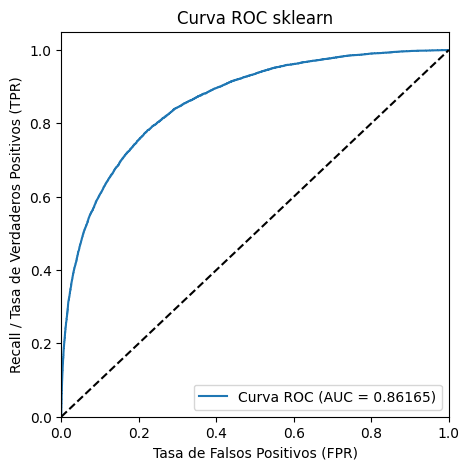

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, sklearn_y_proba)
roc_auc_curve = auc(fpr, tpr)

# gráfica ROC
plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc_curve:.5f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Recall / Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC sklearn')
plt.legend(loc="lower right")
plt.show()

## K-Nearest Neighbors

### Curse of Dimensionality

Para este algoritmo y el de árboles de decisión, se entrenará únicamente con el dataset balanceado, ya que anteriormente se comprobó que este brinda resultados menos sesgados.
Se debe cambiar de DataFrame a numpy array, debido a que es el tipo de dato que manejan de buena manera OurKNearest y OurDecisionTree.

Para KNN, sufrimos de la Maldición de la Dimensionalidad, ya que el testing no se completa debido a un error Out of Memory, debido a la gran cantidad de accesos a memoria que este algoritmo de fuerza bruta debe realizar.
Se intentó aplicar PCA (Principal Component Analysis) para intentar que el algoritmo soporte el dataset reducido, pero incluso reduciéndolo a 2, no es capaz de hacer la predicción, lo que quiere decir que el dataset también en tamaño de muestras es excesivamente grande para el algoritmo.

In [19]:
X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

X_train_np = X_resampled.to_numpy()
y_train_np = y_resampled.to_numpy()

# Principal Component Analysis
pca = PCA(n_components=11)  # número de componentes principales a mantener

# transformación de datos con PCA
X_train_pca = pca.fit_transform(X_train_np)
X_test_pca = pca.transform(X_test_np)

### Entrenamiento

In [ ]:
our_knn = OurKNearest(X_train_pca, y_train_np, n_neighbors=5, weights='distance', n_classes=2)

### Testing

In [ ]:
y_pred_knn = our_knn.predict(X_test_pca)

## Árboles de Decisión

### Entrenamiento

In [ ]:
tree = Node(max_depth=3)
tree.fit(X_train_np, y_train_np)

### Testing

In [ ]:
y_pred_tree = [tree.predict(x) for x in X_test_np]